# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
-[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

PDF Datasheets
- [Hamamatasu](hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R2083_R3377_TPMH1227E.pdf)

In [3]:
# Constants
c = 33.3564 # Speed of Light in cm / ps

In [4]:
scint_radius = 10. # cm
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

In [5]:
# def distance_solver(v, point_pos, center, radius):
#     print("v",v,"CP",point_pos,"radius",radius)
#     CP = center-point_pos
#     OC = center # - (0,0)
#     v = v*-1 if np.dot(v,CP) < 0 else v # make sure vectors v and OP are in same half space\
#     print(v)
#     n = np.cross(v, CP,axisc=2)                 # orthogonal with plane of intersection points and line passing through center
#     print(CP,v, "n",n)
#     perp = normalize(np.cross(v, n)) if np.array(n).ndim > 2 else normalize(v*n)    # perp is parallel to line of intersection and orthogonal to v and n
#     Q2P = OC-radius*perp
#     cosalpha = np.dot(perp, normalize(Q2P))
#     return np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))

In [6]:
#nsin(theta) = n sin(theta)

In [33]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def mag(x):
    return np.linalg.norm(x)
def distance_solver(u, o, center, radius):
    P = o
#     print("u . P", np.dot(u,P))
    D = u*-1 if np.dot(u,P) < 0 else u
    C = center
    R = radius
    bigDelta = P-C
    # t = -D . ∆ ± √(D . ∆)^2 - |D|^2(|∆|^2 - R^2)
    #     over |D|^2
    magDsq = mag(D)**2
    magDeltasq = mag(bigDelta)**2
    DdotDelta = np.dot(D,bigDelta)
    sqrt_term = np.sqrt(DdotDelta**2 - magDsq * (magDeltasq - R**2))/magDsq
    b_term = -DdotDelta/magDsq
    rootA = b_term - sqrt_term
    rootB = b_term + sqrt_term
#     print(f"rootA={rootA} rootB={rootB}")
    return -rootA if (rootA < 0) & (np.dot(u,P) < 0) else (-rootB if np.dot(u,P) < 0 else rootB)

def photon_interaction(u, n, E):
    #  print(f"u_old=({u[0]:.2f},{u[1]:.2f})")
    # FULL internal reflection
    # Need to edit this to use fresnel's equations
    u = u - 2*np.dot(u, n)*n # u_new = u - 2 (u . n)*n
    # print(f"u_new=({u[0]:.2f},{u[1]:.2f})")
    E-= 50*np.random.random() # energy loss / polarization of photon use fresnel equations
    return u, E

def scintillator_monte_carlo(x, y, x_pmt, E, scint_radius, N_max, dt):
    print(f"Starting position (x_0,y_0) = ({x:.2f},{y:.2f})")
    track_history = np.zeros((N_max,5))         # x, y history of Photon
    theta = random.uniform(0,2*np.pi)           # first direction of photon
    u = np.array([np.cos(theta),np.sin(theta)]) # first direction unit vector
    o = np.array([x, y])
    track_history[0] = [x,y,u[0],u[1],E]
    i = 1
    while (i < N_max) & (o[0] < x_pmt) & (E > 0):
        ds = distance_solver(u, o, np.zeros(2),scint_radius)
        x, y = o+ds*u
        dt = ds/c if ds>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: ds={ds:.2f}cm dt={dt:.2f}ps E={E:.2f} xy =({x:.2f},{y:.2f}) u=({u[0]:.2f},{u[1]:.2f})")
        o = np.array([x, y])
        n = normalize(o-np.zeros(2))
        u, E = photon_interaction(u, n, E)
        track_history[i] = [x,y,u[0],u[1],E]
        i+=1
    if i < N_max:
        track_history = track_history[:i+1,:]
    return track_history

Starting position (x_0,y_0) = (-1.69,2.26)
step 1: ds=10.22cm dt=0.31ps E=100.00 xy =(7.62,6.48) u=(0.91,0.41)
step 2: ds=19.22cm dt=0.58ps E=52.19 xy =(-3.02,-9.53) u=(-0.55,-0.83)
step 3: ds=19.22cm dt=0.58ps E=13.90 xy =(-2.49,9.68) u=(0.03,1.00)


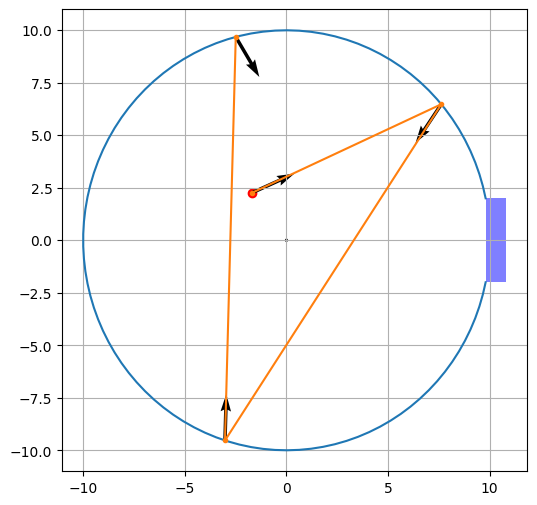

In [34]:
# Plot
fig0, ax0 = plt.subplots(figsize=(6,6))
ax0.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint))
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r)) # x, y
ax0.scatter(random_track[0],random_track[1], color='red', marker='o')
pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
ax0.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track[0],random_track[1], x_pmt=x, E=100, scint_radius=10, N_max=20, dt=0.2)
ax0.quiver(tracks[:,0],tracks[:,1], tracks[:,2], tracks[:,3],scale=10)
line = ax0.plot(tracks[:-1,0],tracks[:-1,1], alpha=1, color='C1', marker='.')
# for i in range(len(tracks[:,4])):
#     line[0].set_alpha(tracks[i,4]/100)
#     plt.
ax0.grid(True)
plt.show()

- figure out if the light tube is useful for this simulation
- find a mean free path and then at each mean calculate the random.poisson(mean) which is the time to the next scintillation
- at the reflection there is a high chance of absorption -> figure out this probability based off of the properties of the scintillator
- fresnel's equation and white paint layer?

### PMT signal making

In [16]:
# Taken from c code resource
def photoElectrons(photons, QE):
    n = 0.
    for i in range(photons):
        if np.random.random()<QE:
            n+=1
    return n
def meanDynodeElectrons(E):
    E_per_Electron = 20
    return E/E_per_Electron if E >= 0 else 0
def genDynodeElectrons(E_incoming, E):
    mean = E_incoming*meanDynodeElectrons(E)
    return np.random.poisson(mean)
def photontoElectrons(photons, voltages, QE, N):
    e = photoElectrons(photons, QE)
    prevV = 0.
    for dynode in range(N):
        delta_voltage = V[dynode] - prevV
        e += genDynodeElectrons(e, delta_voltage)
        prevV = V[dynode]
    return e

In [37]:
n_dynodes = 8
V = np.linspace(150,850,n_dynodes)
# V = [150,300,350,600,750,850]
n_incident_photons = 10000
# QE = 0.23 # original test value
QE = 0.82
pmtSignal = []
for photon in range(n_incident_photons):
    e = photontoElectrons(1, V, QE, n_dynodes)
    if e>1:
        pmtSignal.append(e)

Dynode Voltages = [150. 250. 350. 450. 550. 650. 750. 850.]


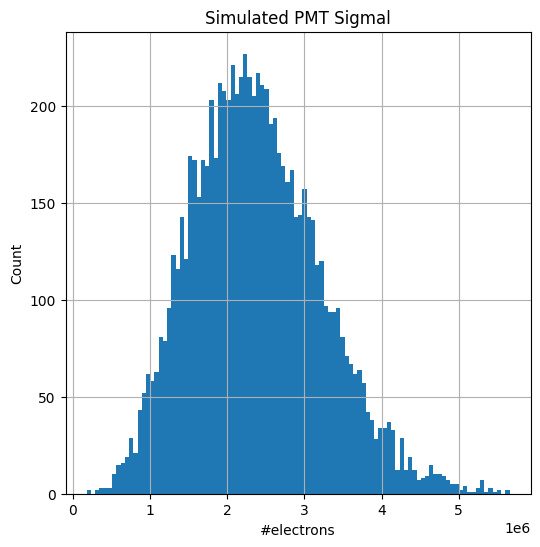

In [38]:
print("Dynode Voltages =", V)
fig1, ax1 = plt.subplots(figsize=(6,6))
counts1, bins1 = np.histogram(pmtSignal, bins=40)
logbins1 = np.logspace(np.log10(bins1[0]),np.log10(bins1[-1]),len(bins1))
ax1.hist(pmtSignal, bins=100)
ax1.set_title('Simulated PMT Sigmal')
ax1.set_ylabel('Count')
ax1.set_xlabel('#electrons')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.grid(True)
plt.show()